In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from ultralytics import YOLO
import os
from shutil import move, copy


In [2]:
data = pd.read_csv('../data/interim/annots_imgs_merged.csv')
dot = data[data['chart-type'] == 'dot']
dot = dot[['data-series','visual-elements.dot points','file_name','image_path']]
dot.columns = ['data_series','data_coords','name','path']
dot.reset_index(drop=True, inplace=True)
dot.head()

,data_series,data_coords,name,path
0,"[{'x': '1900', 'y': 9}, {'x': '2000', 'y': 5},...","[[{'x': 113.33333333333333, 'y': 232.199999999...",722775563cdf,../data/interim/Dotplots/722775563cdf.jpg
1,"[{'x': 'Plot 169', 'y': 2}, {'x': 'Plot 170', ...","[[{'x': 111.33333333333333, 'y': 233.0}, {'x':...",541072efa16e,../data/interim/Dotplots/541072efa16e.jpg
2,"[{'x': '1985', 'y': 6}, {'x': '1992', 'y': 5},...","[[{'x': 118.39999999999999, 'y': 237.386666666...",08b5c8e2dc12,../data/interim/Dotplots/08b5c8e2dc12.jpg
3,"[{'x': 'Sasvad', 'y': 9}, {'x': 'Soron', 'y': ...","[[{'x': 102.4, 'y': 67.71666666666667}, {'x': ...",75acb35b82b5,../data/interim/Dotplots/75acb35b82b5.jpg
4,"[{'x': '1985', 'y': 7}, {'x': '1992', 'y': 3},...","[[{'x': 118.0, 'y': 113.23333333333335}, {'x':...",87acdd66b8e5,../data/interim/Dotplots/87acdd66b8e5.jpg


In [3]:
model = YOLO('/Users/matt/Desktop/graphs-capstone/data/YOLO/Dotplots/runs/detect/train2/weights/best.pt')

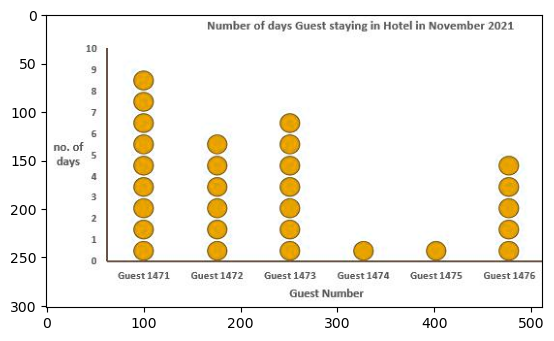

In [4]:
# Test image
path = dot['path'].values[3003]
img = cv2.imread(path)
plt.imshow(img)
plt.show()

In [5]:
# Predict on the image
results = model(path)


image 1/1 /Users/matt/Desktop/graphs-capstone/notebooks/../data/interim/Dotplots/8378ef55e79e.jpg: 384x640 29 dots, 362.0ms
Speed: 21.8ms preprocess, 362.0ms inference, 30.6ms postprocess per image at shape (1, 3, 384, 640)


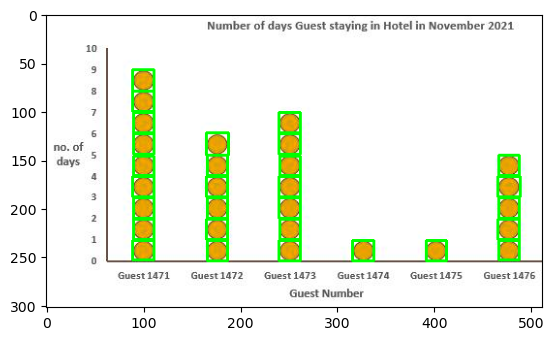

In [6]:
# Extract bboxes from model prediction
bbox_pred = []
res = results[0].boxes.data
for bbox in res:
    x1, y1, x2, y2, probs, pred = bbox
    bbox_pred.append((int(x1.item()), int(y1.item()), int(x2.item()), int(y2.item())))


copy = img.copy()
for bbox in bbox_pred:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(copy)
plt.show()

In [16]:
# Extract actual bboxes from data
data = dot['data_coords'].values[3001]
data = data.replace("'","\"")
data_list = json.loads(data)
bbox_actual = []
for row in data_list[0]:
    x1 = row['x'] - 10
    y1 = row['y'] - 10
    x2 = row['x'] + 10
    y2 = row['y'] + 10
    bbox_actual.append((x1,y1,x2,y2))

bbox_pred = sorted(bbox_pred)
bbox_actual = sorted(bbox_actual)

actual_df = pd.DataFrame(bbox_actual, columns=['x1','y1','x2','y2'])
pred_df = pd.DataFrame(bbox_pred, columns=['x1_pred','y1_pred','x2_pred','y2_pred'])

mean_diff_x1 = abs(pred_df['x1_pred']-actual_df['x1']).mean()
mean_diff_y1 = abs(pred_df['y1_pred']-actual_df['y1']).mean()
mean_diff_x2 = abs(pred_df['x2_pred']-actual_df['x2']).mean()
mean_diff_y2 = abs(pred_df['y2_pred']-actual_df['y2']).mean()

In [18]:
print(mean_diff_x1, mean_diff_y1, mean_diff_x2, mean_diff_y2)

0.7634408602150603 36.406451612903226 0.7526881720430189 36.148387096774194


# Testing on the Rest of the dot plots:

In [7]:
test_df = dot[3001:].reset_index(drop=True)
test_df.head()

,data_series,data_coords,name,path
0,"[{'x': 'id. 8754', 'y': 4}, {'x': 'id. 6778', ...","[[{'x': 103.33333333333333, 'y': 249.933333333...",8b1378118fb8,../data/interim/Dotplots/8b1378118fb8.jpg
1,"[{'x': '2004', 'y': 3}, {'x': '2007', 'y': 5},...","[[{'x': 120.66666666666667, 'y': 237.233333333...",f6351ac4383c,../data/interim/Dotplots/f6351ac4383c.jpg
2,"[{'x': 'Guest 1471', 'y': 9}, {'x': 'Guest 147...","[[{'x': 100.0, 'y': 244.40000000000003}, {'x':...",8378ef55e79e,../data/interim/Dotplots/8378ef55e79e.jpg
3,"[{'x': '1985', 'y': 1}, {'x': '1996', 'y': 8},...","[[{'x': 118.66666666666667, 'y': 237.566666666...",f7e4ce13d903,../data/interim/Dotplots/f7e4ce13d903.jpg
4,"[{'x': '00-3', 'y': 6}, {'x': '3-6', 'y': 9}, ...","[[{'x': 116.33333333333333, 'y': 236.366666666...",99cdc3c51d1f,../data/interim/Dotplots/99cdc3c51d1f.jpg


In [8]:
dataframes = []
for i in range(len(test_df)):
    # extract xy coordinates from data_coords column
    coords = test_df['data_coords'][i]
    coords = coords.replace("'", "\"")
    coords_list = json.loads(coords)

    # extract important image info
    path = test_df['path'][i]
    name = test_df['name'][i]
    img = cv2.imread(path)
    height = img.shape[0]
    width = img.shape[1]

    # Save the xy coords into a list
    xy_coords = []
    for data_point in coords_list[0]:
        xy_coords.append((data_point['x'],data_point['y']))

    # Transform the xy coords into YOLO bboxes 
    bboxes = []
    for xy in xy_coords:
        x, y = xy
        bbox = (int(x)/width, int(y)/height, 20/width, 20/height)
        bboxes.append(bbox)

    # Save into list of dataframe
    yolo = pd.DataFrame(bboxes, columns=['x','y','w','h'])
    yolo['class'] = 0
    yolo['path'] = path
    yolo['name'] = name
    yolo = yolo[['path','name','class','x','y','w','h']]
    dataframes.append(yolo)

# Concat dataframes and check that the number of unique images is correct
yolo_df = pd.concat(dataframes)
yolo_df['path'].nunique()

2130

In [11]:
yolo_df

,path,name,class,x,y,w,h
0,../data/interim/Dotplots/8b1378118fb8.jpg,8b1378118fb8,0,0.201961,0.787975,0.039216,0.063291
1,../data/interim/Dotplots/8b1378118fb8.jpg,8b1378118fb8,0,0.203922,0.718354,0.039216,0.063291
2,../data/interim/Dotplots/8b1378118fb8.jpg,8b1378118fb8,0,0.200000,0.648734,0.039216,0.063291
3,../data/interim/Dotplots/8b1378118fb8.jpg,8b1378118fb8,0,0.200000,0.575949,0.039216,0.063291
4,../data/interim/Dotplots/8b1378118fb8.jpg,8b1378118fb8,0,0.343137,0.787975,0.039216,0.063291
...,...,...,...,...,...,...,...
26,../data/interim/Dotplots/a6092bafebe8.jpg,a6092bafebe8,0,0.908203,0.501730,0.039062,0.069204
27,../data/interim/Dotplots/a6092bafebe8.jpg,a6092bafebe8,0,0.904297,0.435986,0.039062,0.069204
28,../data/interim/Dotplots/a6092bafebe8.jpg,a6092bafebe8,0,0.908203,0.363322,0.039062,0.069204
29,../data/interim/Dotplots/a6092bafebe8.jpg,a6092bafebe8,0,0.906250,0.290657,0.039062,0.069204


In [10]:
cols = ['name','class','x','y','w','h']
groupby_obj_df = yolo_df[cols].groupby('name')

In [12]:
src_folder = '/Users/matt/Desktop/graphs-capstone/data/interim/Dotplots'
test_folder = '/Users/matt/Desktop/graphs-capstone/data/YOLO/Dotplots/test'

In [13]:
def save_data(filename, folder_path, group_obj):
    #copy image
    src = os.path.join(src_folder,filename)+'.jpg'
    dst = os.path.join(folder_path, filename)+'.jpg'
    copy(src, dst)

    #save labels
    text_filename = os.path.join(folder_path,filename+'.txt')
    group_obj.get_group(filename).set_index('name').to_csv(text_filename, index=False, header=False, sep=' ')

In [14]:
filename_series = pd.Series(groupby_obj_df.groups.keys())
filename_series.apply(save_data,args=(test_folder, groupby_obj_df))

0       None
1       None
2       None
3       None
4       None
        ... 
2125    None
2126    None
2127    None
2128    None
2129    None
Length: 2130, dtype: object

In [15]:
metrics = model.val(data='/Users/matt/Desktop/graphs-capstone/data/YOLO/Dotplots/data.yaml')

Ultralytics YOLOv8.0.136 🚀 Python-3.11.3 torch-2.0.1 CPU (Intel Core(TM) i5-8210Y 1.60GHz)
val: Scanning /Users/matt/Desktop/graphs-capstone/data/YOLO/Dotplots/test... 2130 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2130/2130 [00:03<00:00, 542.78it/s]
val: New cache created: /Users/matt/Desktop/graphs-capstone/data/YOLO/Dotplots/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 134/134 [08:16<00:00,  3.70s/it]
                   all       2130      72560      0.987      0.987      0.993      0.616
Speed: 3.2ms preprocess, 212.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val
